# import libraries

In [ ]:
!git clone https://github.com/davidkim0523/Momentum.git --quiet
!pip install git+https://github.com/quantopian/pyfolio --quiet

     |████████████████████████████████| 52 kB 1.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt

# Class 설계

In [ ]:
import numpy as np
import pandas as pd
import pyfolio as pf


class Momentum():
    def __init__(self, prices, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection,
                 cost=0.001, signal_method='macd', weightings='ew', long_only=False, show_signals=True, show_analytics=True, show_weights=False):
        self.returns = self.get_returns(prices)
        self.holding_returns = self.get_holding_returns(prices, holding_period)

        if signal_method == 'ma':
            self.signal = self.moving_average_breakthrough(prices, lookback_period, long_only)
        elif signal_method == 'ma_co':
            self.signal = self.moving_average_crossover(prices, short_lookback_period, long_lookback_period, long_only)
        elif signal_method == 'cb':
            self.signal = self.channel_breakthrough(prices, lookback_period, long_only)
        elif signal_method == 'macd':
            self.signal = self.macd(prices, long_only)
        elif signal_method == 'am':
            self.signal = self.absolute_momentum(prices, lookback_period, long_only)
        elif signal_method == 'rm':
            self.signal = self.relative_momentum(prices, lookback_period, n_selection, long_only)
        elif signal_method == 'dm':
            self.signal = self.dual_momentum(prices, lookback_period, n_selection, long_only)

        if weightings == 'ew':
            self.cs_risk_weight = self.equal_weight(self.signal)
        elif weightings == 'emv':
            self.cs_risk_weight = self.equal_marginal_volatility(self.returns, self.signal)

        self.rebalance_weight = 1 / holding_period
        self.cost = self.transaction_cost(self.signal, cost)

        self.port_rets_wo_cash = self.backtest(self.holding_returns, self.signal, self.cost, self.rebalance_weight,
                                               self.cs_risk_weight)

        self.ts_risk_weight = self.volatility_targeting(self.port_rets_wo_cash)

        self.port_rets = self.port_rets_wo_cash * self.ts_risk_weight

        if show_signals == True:
            print(self.signal)

        if show_analytics == True:
            self.performance_analytics(self.port_rets)
            
        if show_weights == True:
            self.plot_weights(self.cs_risk_weight, self.ts_risk_weight)


    def get_returns(self, prices):
        """Returns the historical daily returns

        Parameters
        ---------
        prices : dataframe
            Historical daily prices

        Returns
        -------
        returns : dataframe
            Historical daily returns
        """
        returns = prices.pct_change().fillna(0)
        return returns

    def get_holding_returns(self, prices, holding_period):
        """Returns the periodic returns for each holding period

        Parameters
        ---------
        returns : dataframe
            Historical daily returns
        holding_period : int
            Holding Period

        Returns
        -------
        holding_returns : dataframe
            Periodic returns for each holding period. Pulled by N (holding_period) days forward to keep inline with trading signals.
        """
        holding_returns = prices.pct_change(periods=holding_period).shift(-holding_period).fillna(0)
        return holding_returns


    def moving_average_breakthrough(self, prices, lookback, long_only=False):
        """Returns Moving Average Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback window for signal generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            Moving Average Breakthrough signals
        """
        mv_avrg = prices.rolling(lookback).mean().fillna()
        long_signal = (prices > mv_avrg).applymap(self.bool_converter)
        short_signal = -(prices < mv_avrg).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal

    def moving_average_crossover(self, prices, short_lookback, long_lookback, long_only=False):
        """Returns Moving Average Crossover Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        short_lookback : int
            Short lookback window for signal generation
        long_lookback : int
            Long lookback window for signal generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            Moving Average Crossover signals
        """
        shrt_mv_avrg = prices.rolling(short_lookback).mean().fillna()
        long_mv_avrg = prices.rolling(long_lookback).mean().fillna()
        long_signal = (shrt_mv_avrg > long_mv_avrg).applymap(self.bool_converter)
        short_signal = -(shrt_mv_avrg < long_mv_avrg).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal

    def channel_breakthrough(self, prices, lookback, long_only=False):
        """Returns Channel Breakthrough Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback window for signal generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            Channel Breakthrough signals
        """
        high_price_chnl = prices.rolling(lookback).max()
        low_price_chnl = prices.rolling(lookback).min()
        long_signal = (prices > high_price_chnl).applymap(self.bool_converter)
        long_exit_signal = -(prices < high_price_chnl).applymap(self.bool_converter)
        short_signal = -(prices < low_price_chnl).applymap(self.bool_converter)
        short_exit_signal = (prices > low_price_chnl).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = ((long_signal + long_exit_signal) + (short_signal + short_exit_signal))/2
        return signal

    def macd(self, prices, long_only=False):
        """Returns MACD Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            MACD signals
        """
        macd = prices.rolling(window=12).mean() - prices.rolling(window=26).mean()
        signl = prices.rolling(window=9).mean()
        long_signal = (macd > signl).applymap(self.bool_converter)
        short_signal = -(macd < signl).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def absolute_momentum(self, prices, lookback, long_only=False):
        """Returns Absolute Momentum Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback window for signal generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        returns : dataframe
            Absolute momentum signals
        """
        returns = prices.pct_change(periods=lookback).fillna(0)
        long_signal = (returns > 0).applymap(self.bool_converter)
        short_signal = -(returns < 0).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def relative_momentum(self, prices, lookback, n_selection, long_only=False):
        """Returns Relative Momentum Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        n_selection : int
            Number of asset to be traded at one side
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            Relative momentum signals
        """
        returns = prices.pct_change(periods=lookback).fillna(0)
        rank = returns.rank(axis=1, ascending=False)
        long_signal = (rank <= n_selection).applymap(self.bool_converter)
        short_signal = -(rank >= len(rank.columns) - n_selection + 1).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def dual_momentum(self, prices, lookback, n_selection, long_only=False):
        """Returns Dual Momentum Signals

        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        n_selection : int
            Number of asset to be traded at one side
        long_only : bool, optional
            Indicator for long-only momentum, False is default value

        Returns
        -------
        signal : dataframe
            Dual momentum signals
        """
        abs_signal = self.absolute_momentum(prices, lookback, long_only)
        rel_signal = self.relative_momentum(prices, lookback, n_selection, long_only)
        signal = (abs_signal == rel_signal).applymap(self.bool_converter) * abs_signal
        return signal

    def equal_weight(self, signal):
        """Returns Equal Weights

        Parameters
        ----------
        signal : dataframe
            Momentum signal dataframe

        Returns
        -------
        weight : dataframe
            Equal weights for cross-asset momentum portfolio
        """
        total_signal = 1 / abs(signal).sum(axis=1)
        total_signal.replace([np.inf, -np.inf], 0, inplace=True)
        weight = pd.DataFrame(index=signal.index, columns=signal.columns).fillna(value=1)
        weight = weight.mul(total_signal, axis=0)
        return weight

    def equal_marginal_volatility(self, returns, signal):
        """Returns Equal Marginal Volatility (Inverse Volatility)

        Parameters
        ----------
        returns : dataframe
            Historical daily returns
        signal : dataframe
            Momentum signal dataframe

        Returns
        -------
        weight : dataframe
            Weights using equal marginal volatility
        """
        vol = (returns.rolling(252).std() * np.sqrt(252)).fillna(0)
        vol_signal = vol * abs(signal)
        inv_vol = 1 / vol_signal
        inv_vol.replace([np.inf, -np.inf], 0, inplace=True)
        weight = inv_vol.div(inv_vol.sum(axis=1), axis=0).fillna(0)
        return weight

    def volatility_targeting(self, returns, target_vol=0.01):
        """Returns Weights based on Vol Target

        Parameters
        ----------
        returns : dataframe
            Historical daily returns of backtested portfolio
        target_vol : float, optional
            Target volatility, Default target volatility is 1%

        Returns
        -------
        weights : dataframe
            Weights using equal marginal volatility
        """
        weight = target_vol / (returns.rolling(252).std() * np.sqrt(252)).fillna(0)
        weight.replace([np.inf, -np.inf], 0, inplace=True)
        weight = weight.shift(1).fillna(0)
        return weight

    def transaction_cost(self, signal, cost=0.001):
        """Returns Transaction Costs

        Parameters
        ----------
        signal : dataframe
            Momentum signal dataframe
        cost : float, optional
            Transaction cost (%) per each trade. The default is 0.001.
        Returns
        -------
        cost_df : dataframe
            Transaction cost dataframe
        """
        cost_df = (signal.diff() != 0).applymap(self.bool_converter) * cost
        cost_df.iloc[0] = 0
        return cost_df

    def backtest(self, returns, signal, cost, rebalance_weight, weighting):
        """Returns Portfolio Returns without Time-Series Risk Weights
        Parameters
        ----------
        returns : dataframe
            Historical daily returns
        signal : dataframe
            Momentum signal dataframe
        cost : dataframe
            Transaction cost dataframe
        rebalance_weight : float
            Rebalance weight
        weighting : dataframe
            Weighting dataframe
        Returns
        -------
        port_rets : dataframe
            Portfolio returns dataframe without applying time-series risk model
        """
        port_rets = ((signal * returns - cost) * rebalance_weight * weighting).sum(axis=1)
        return port_rets

    def performance_analytics(self, returns):
        """Returns Perforamnce Analytics using pyfolio package
        Parameters
        ----------
        returns : series
            backtestd portfolio returns
        Returns
        -------
        None
        """
        pf.create_returns_tear_sheet(returns)

    def bool_converter(self, bool_var):
        """Returns Integer Value from Boolean Value
        Parameters
        ----------
        bool_var : boolean
            Boolean variables representing trade signals
        Returns
        -------
        result : int
            Integer variables representing trade signals
        """
        if bool_var == True:
            result = 1
        elif bool_var == False:
            result = 0
        return result
    
    def plot_weights(self, cs_risk_weight, ts_risk_weight):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 9), sharex=True)
        ax1 = axes[0]
        ax2 = axes[1]
        ax1.stackplot(cs_risk_weight.index, np.transpose(cs_risk_weight),
                      labels=cs_risk_weight.columns);
        _ = ax1.set_title('Cross-Sectional Weights', fontsize=15, family='Arial');
        _ = ax1.set_ylabel('weights', fontsize=15, family='Arial');
        _ = ax1.set_xlabel('date', fontsize=15, family='Arial');
        ax1.legend(loc="upper left")

        ax2.stackplot(ts_risk_weight.index, ts_risk_weight);
        _ = ax2.set_title('Time-Series Weights', fontsize=15, family='Arial');
        _ = ax2.set_ylabel('weights', fontsize=15, family='Arial');
        _ = ax2.set_xlabel('date', fontsize=15, family='Arial');
        ax2.legend(loc="upper left")

In [ ]:
def load_data(url):
    """Returns price dataframe from given URL
    Parameters
    ----------
    url : string
    URL which contains dataset
    Returns
    -------
    df : dataframe
    Imported price dataframe from URL
    """

    price_df = pd.read_csv(url).dropna()
    price_df.index = pd.to_datetime(price_df['Date'])
    price_df = price_df.drop(columns=['Date'])
    return price_df

In [ ]:
url = 'https://raw.githubusercontent.com/davidkim0523/Momentum/main/Data.csv'
prices = load_data(url)
equity = prices.iloc[:, 0:9]
currency = prices.iloc[:, 9:17]
commodity = prices.iloc[:, 17:26]
fixedincome = prices.iloc[:, 26:]

# Signal Vector

## Total Portfolio

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 19

port_mom = Momentum(prices, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_analytics=False)

            DAX Index  Eurostoxx 50 Index  ...  AGB 3Y  AGB 10Y
Date                                       ...                 
2000-01-03          0                   0  ...       0        0
2000-01-04          0                   0  ...       0        0
2000-01-05          0                   0  ...       0        0
2000-01-06          0                   0  ...       0        0
2000-01-07          0                   0  ...       0        0
...               ...                 ...  ...     ...      ...
2021-05-31         -1                  -1  ...      -1       -1
2021-06-01         -1                  -1  ...      -1       -1
2021-06-02         -1                  -1  ...      -1       -1
2021-06-03         -1                  -1  ...      -1       -1
2021-06-04         -1                  -1  ...      -1       -1

[5590 rows x 38 columns]


## Equity

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

equity_mom = Momentum(equity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_analytics=False)

            DAX Index  Eurostoxx 50 Index  ...  KOSPI 200 Index  Hang Seng Index
Date                                       ...                                  
2000-01-03          0                   0  ...                0                0
2000-01-04          0                   0  ...                0                0
2000-01-05          0                   0  ...                0                0
2000-01-06          0                   0  ...                0                0
2000-01-07          0                   0  ...                0                0
...               ...                 ...  ...              ...              ...
2021-05-31         -1                  -1  ...               -1               -1
2021-06-01         -1                  -1  ...               -1               -1
2021-06-02         -1                  -1  ...               -1               -1
2021-06-03         -1                  -1  ...               -1               -1
2021-06-04         -1       

## Currency

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

currency_mom = Momentum(currency, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_analytics=False)

            EURUSD  GBPUSD  SEKUSD  CADUSD  JPYUSD  AUDUSD  NZDUSD  USDKRW
Date                                                                      
2000-01-03       0       0       0       0       0       0       0       0
2000-01-04       0       0       0       0       0       0       0       0
2000-01-05       0       0       0       0       0       0       0       0
2000-01-06       0       0       0       0       0       0       0       0
2000-01-07       0       0       0       0       0       0       0       0
...            ...     ...     ...     ...     ...     ...     ...     ...
2021-05-31      -1      -1      -1      -1      -1      -1      -1      -1
2021-06-01      -1      -1      -1      -1      -1      -1      -1      -1
2021-06-02      -1      -1      -1      -1      -1      -1      -1      -1
2021-06-03      -1      -1      -1      -1      -1      -1      -1      -1
2021-06-04      -1      -1      -1      -1      -1      -1      -1      -1

[5590 rows x 8 columns]


## Commodity

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

commodity_mom = Momentum(commodity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_analytics=False)

            Brent Crude  WTI Crude  Heating Oil  ...  Copper  Corn  Soybean
Date                                             ...                       
2000-01-03            0          0            0  ...       0     0        0
2000-01-04            0          0            0  ...       0     0        0
2000-01-05            0          0            0  ...       0     0        0
2000-01-06            0          0            0  ...       0     0        0
2000-01-07            0          0            0  ...       0     0        0
...                 ...        ...          ...  ...     ...   ...      ...
2021-05-31           -1         -1           -1  ...      -1    -1       -1
2021-06-01           -1         -1           -1  ...      -1    -1       -1
2021-06-02           -1         -1           -1  ...      -1    -1       -1
2021-06-03           -1         -1           -1  ...      -1    -1       -1
2021-06-04           -1         -1           -1  ...      -1    -1       -1

[5590 rows 

## FixedIncome

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 7

fixedincome_mom = Momentum(fixedincome, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_analytics=False)

            Eurodollar  UST 2Y  UST 5Y  ...  JGB 10Y  AGB 3Y  AGB 10Y
Date                                    ...                          
2000-01-03           0       0       0  ...        0       0        0
2000-01-04           0       0       0  ...        0       0        0
2000-01-05           0       0       0  ...        0       0        0
2000-01-06           0       0       0  ...        0       0        0
2000-01-07           0       0       0  ...        0       0        0
...                ...     ...     ...  ...      ...     ...      ...
2021-05-31          -1      -1      -1  ...       -1      -1       -1
2021-06-01          -1      -1      -1  ...       -1      -1       -1
2021-06-02          -1      -1      -1  ...       -1      -1       -1
2021-06-03          -1      -1      -1  ...       -1      -1       -1
2021-06-04          -1      -1      -1  ...       -1      -1       -1

[5590 rows x 12 columns]


# Bactesting Performace with pyfolio

## Total Portfolio

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,-3.476%
Cumulative returns,-54.374%
Annual volatility,1.229%
Sharpe ratio,-2.87
Calmar ratio,-0.06
Stability,0.95
Max drawdown,-59.739%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,59.74,2002-01-23,2021-05-06,NaT,NaN
1,3.48,2000-12-19,2000-12-28,2001-01-18,23
2,2.81,2001-06-27,2001-10-23,2002-01-10,142
3,0.16,2001-03-30,2001-04-12,2001-04-18,14
4,0.03,2001-04-19,2001-04-24,2001-04-26,6


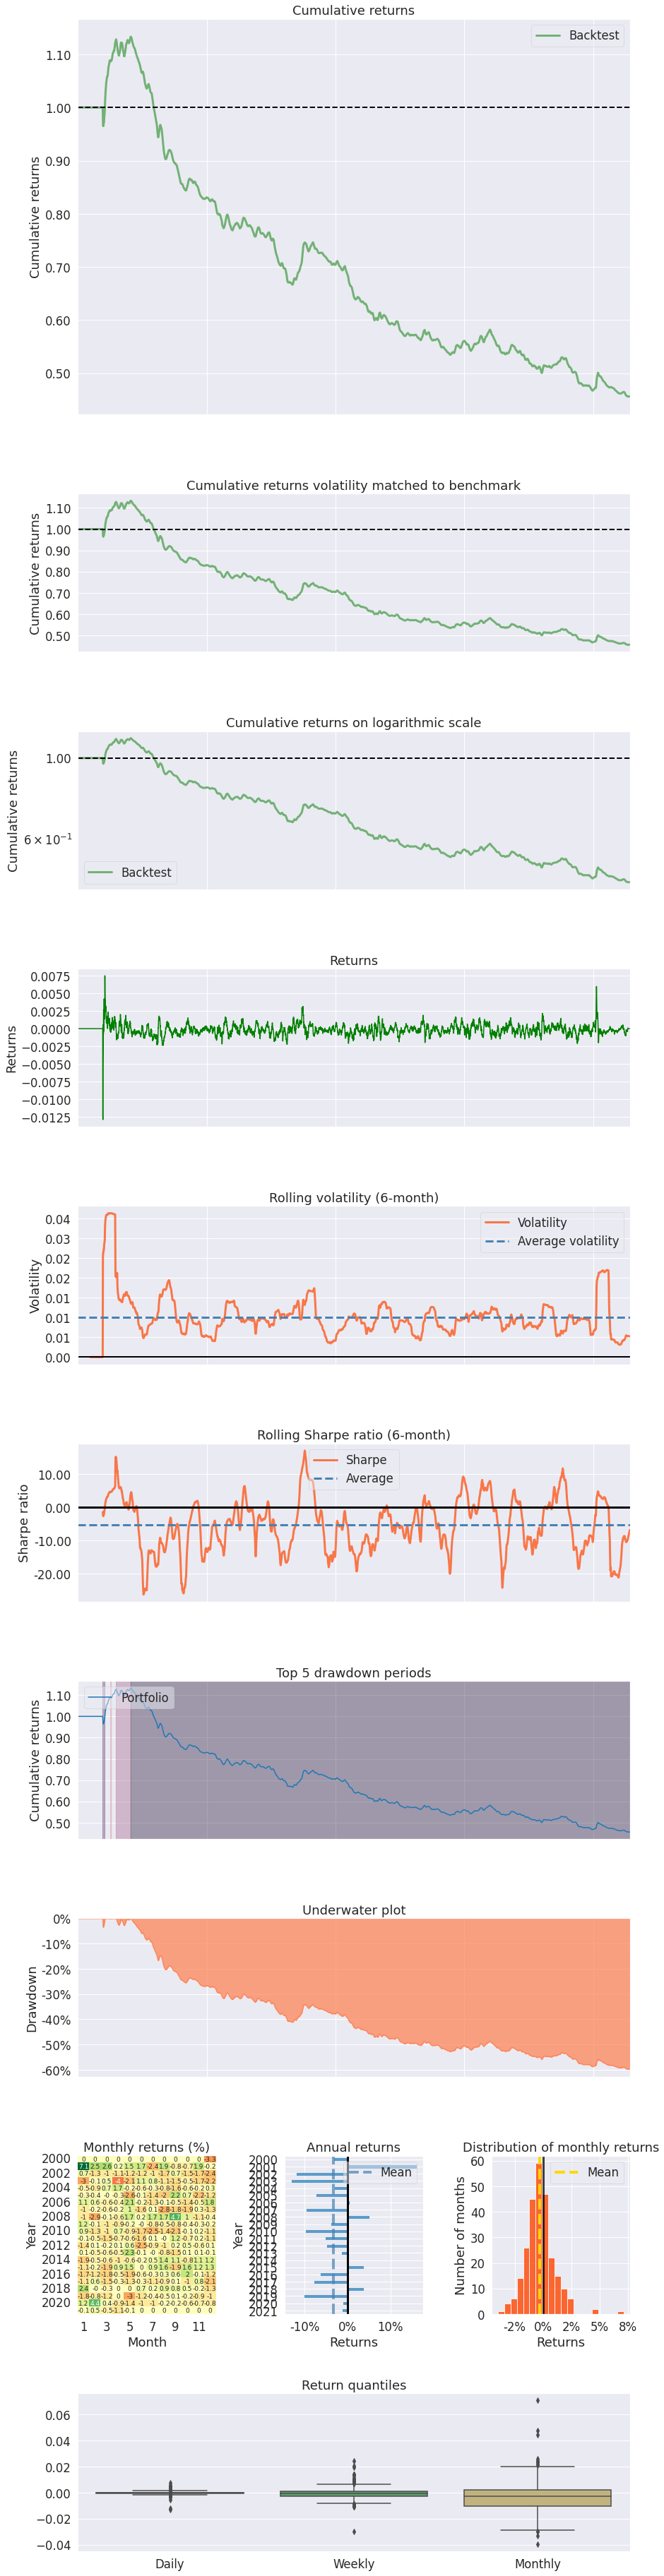

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 19

momentum = Momentum(prices, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False)

## Equity

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,-2.851%
Cumulative returns,-47.359%
Annual volatility,1.763%
Sharpe ratio,-1.63
Calmar ratio,-0.06
Stability,0.93
Max drawdown,-50.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,50.25,2003-03-04,2021-04-12,NaT,NaN
1,11.55,2000-12-19,2001-01-11,2001-08-28,181
2,3.38,2001-09-11,2002-03-01,2002-06-26,207
3,1.74,2002-09-18,2002-11-14,2003-01-14,85
4,0.48,2002-07-18,2002-08-05,2002-08-21,25


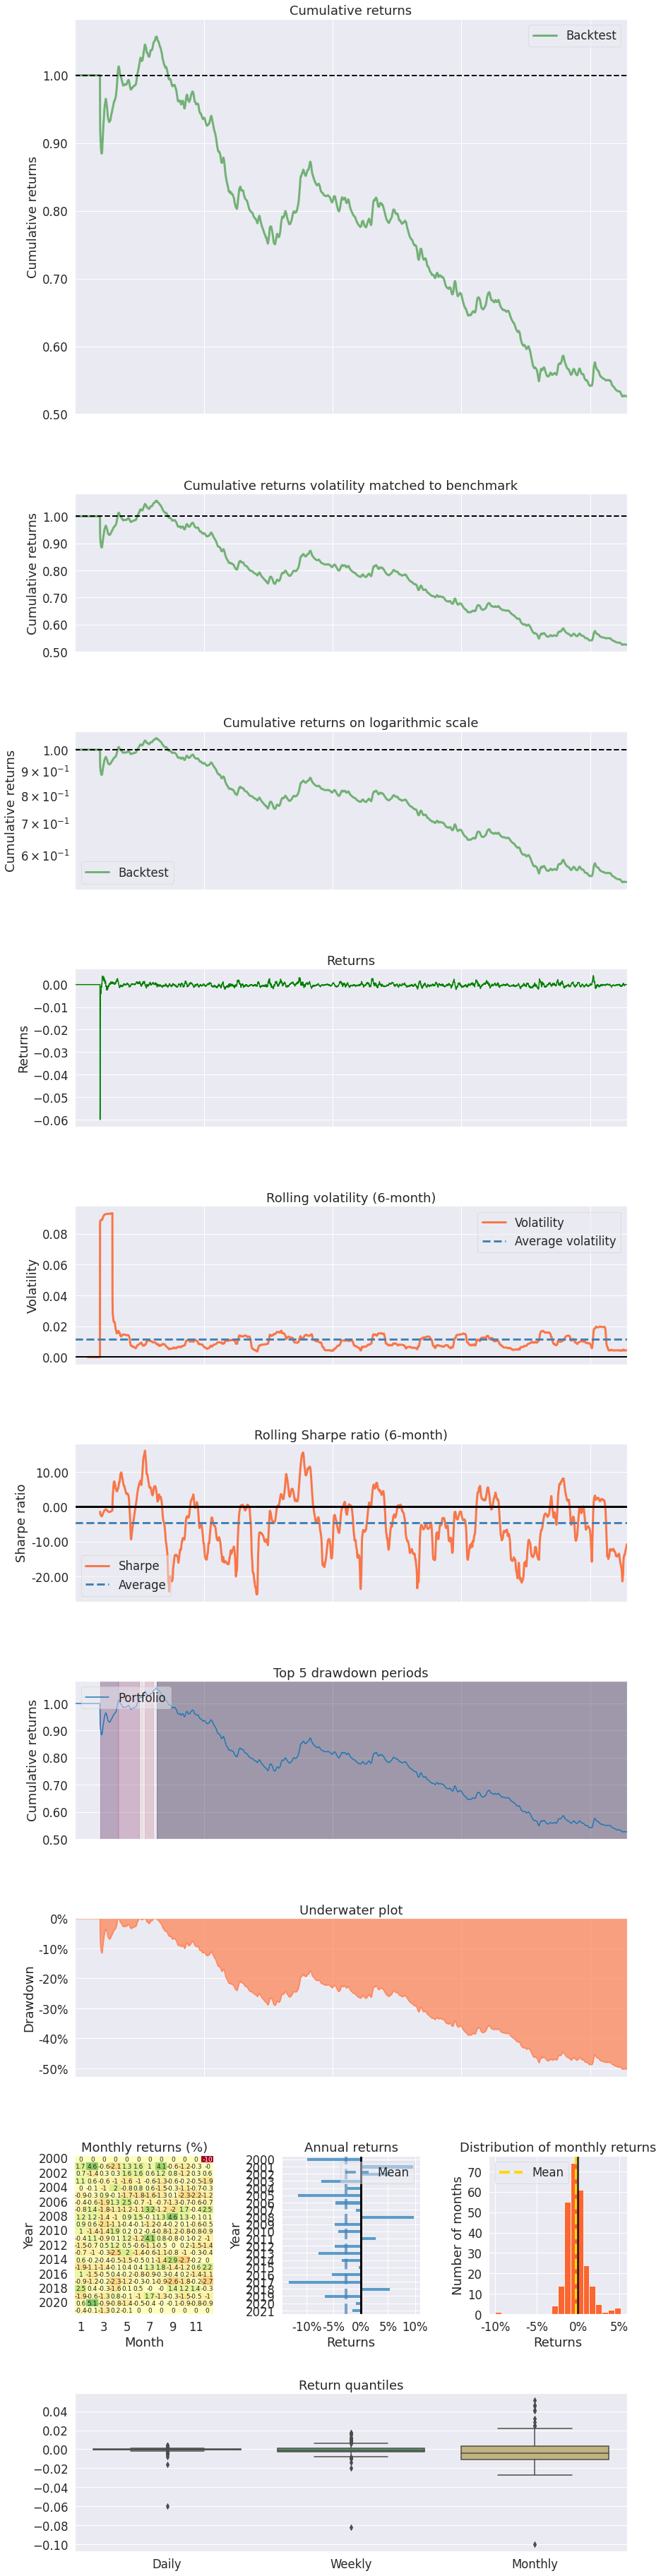

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

equity_mom = Momentum(equity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False)

## Currency

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,-0.287%
Cumulative returns,-6.169%
Annual volatility,1.175%
Sharpe ratio,-0.24
Calmar ratio,-0.01
Stability,0.03
Max drawdown,-35.808%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.81,2002-01-24,2011-07-20,NaT,NaN
1,2.85,2001-06-26,2001-08-14,2002-01-09,142
2,1.45,2001-03-14,2001-04-24,2001-05-21,49
3,1.25,2000-12-19,2000-12-25,2000-12-29,9
4,0.06,2001-06-19,2001-06-21,2001-06-26,6


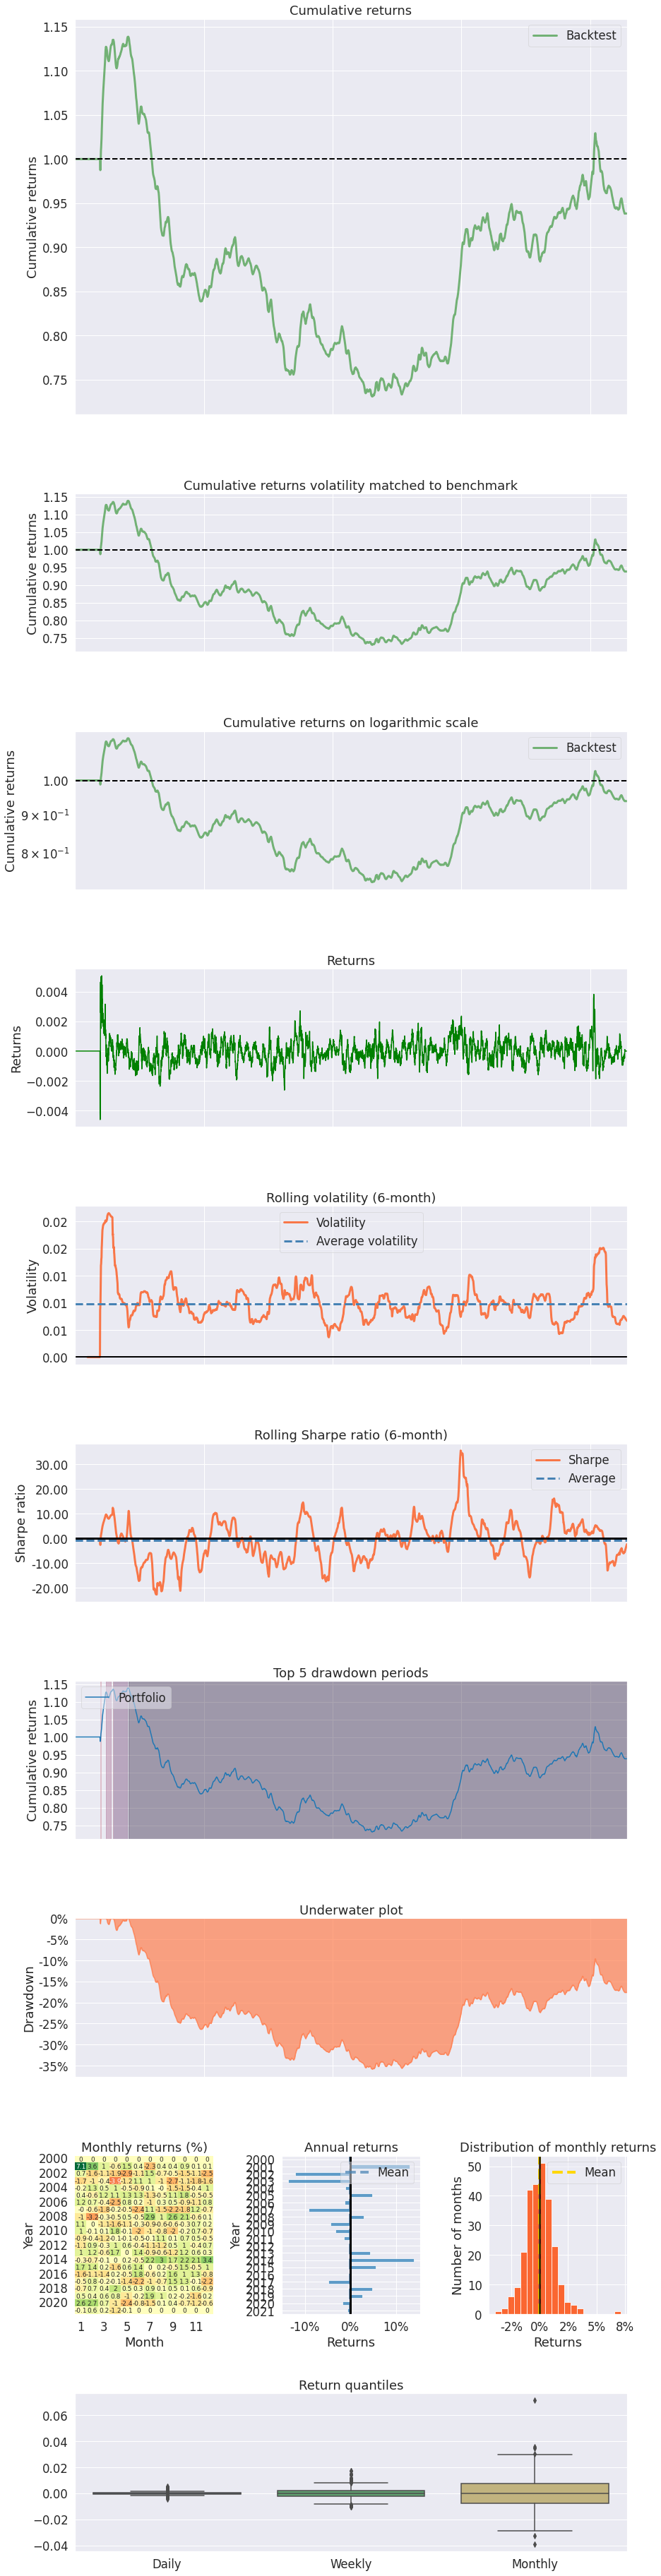

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

currency_mom = Momentum(currency, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False)

## Commodity

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,-0.591%
Cumulative returns,-12.317%
Annual volatility,1.233%
Sharpe ratio,-0.47
Calmar ratio,-0.02
Stability,0.34
Max drawdown,-38.394%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.39,2002-01-11,2011-04-05,NaT,NaN
1,0.52,2001-03-13,2001-03-22,2001-04-13,24
2,0.46,2001-11-23,2001-12-14,2001-12-27,25
3,0.44,2001-04-18,2001-04-30,2001-05-22,25
4,0.31,2001-06-26,2001-07-05,2001-07-12,13


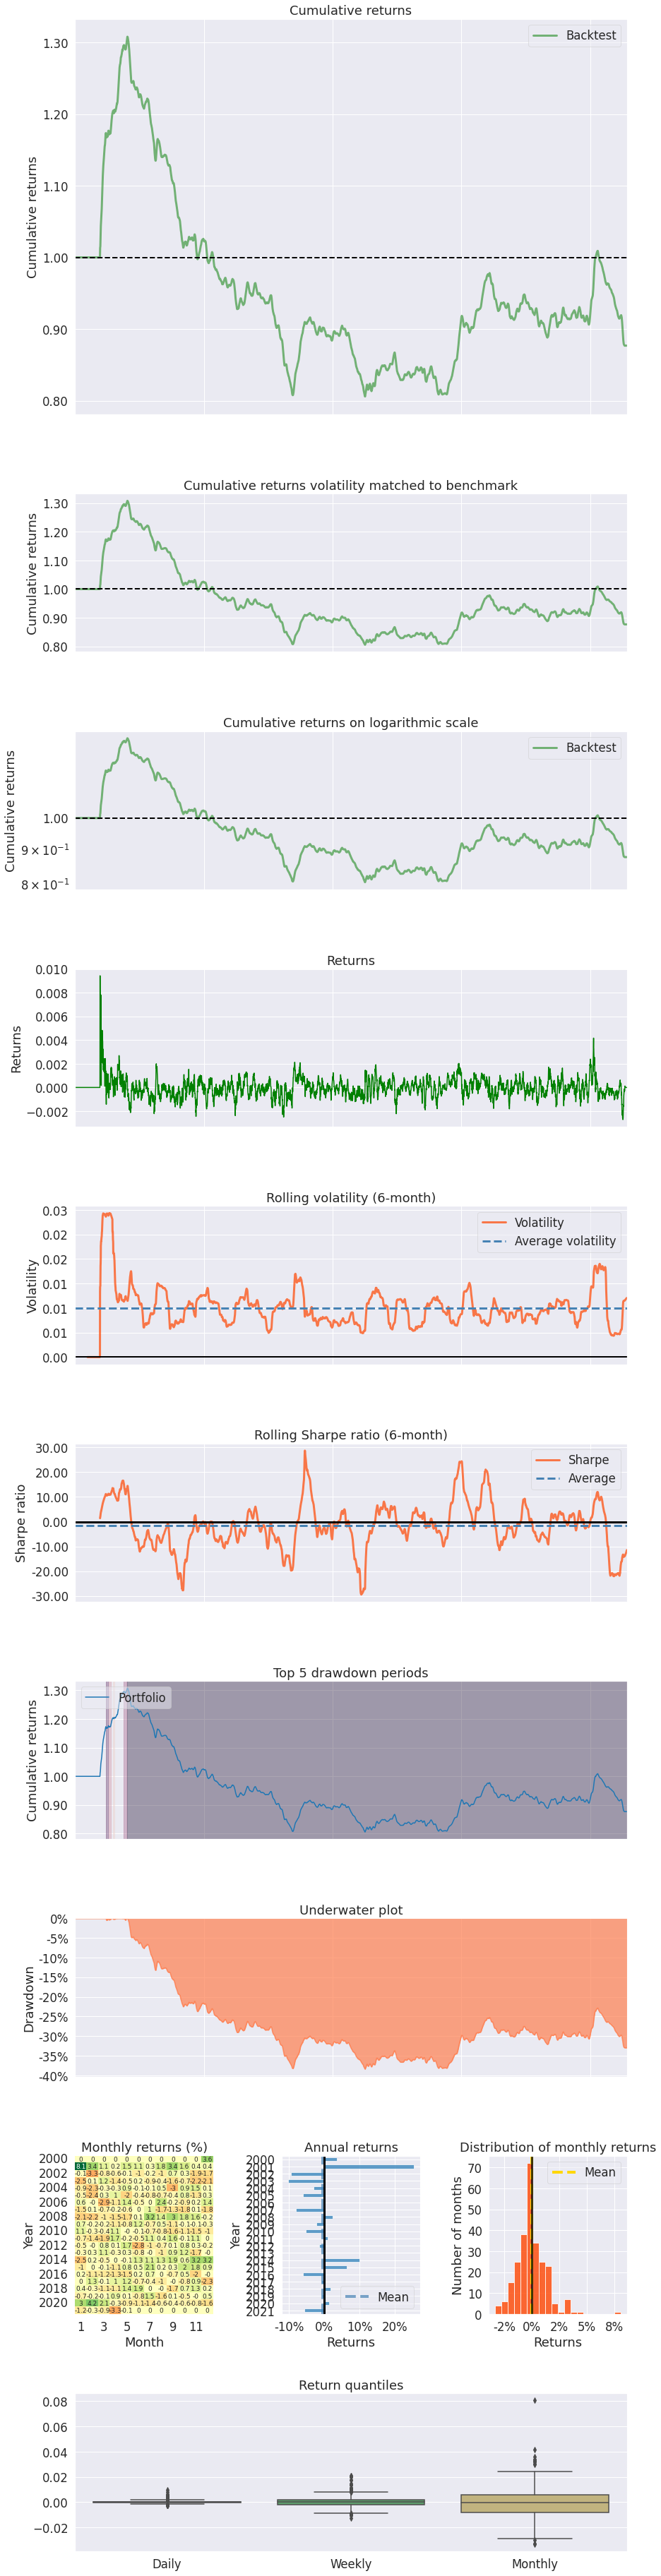

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 5

commodity_mom = Momentum(commodity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False)

## FixedIncome

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,-3.36%
Cumulative returns,-53.142%
Annual volatility,1.18%
Sharpe ratio,-2.89
Calmar ratio,-0.06
Stability,0.96
Max drawdown,-54.329%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,54.33,2000-12-19,2020-10-09,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: ignored

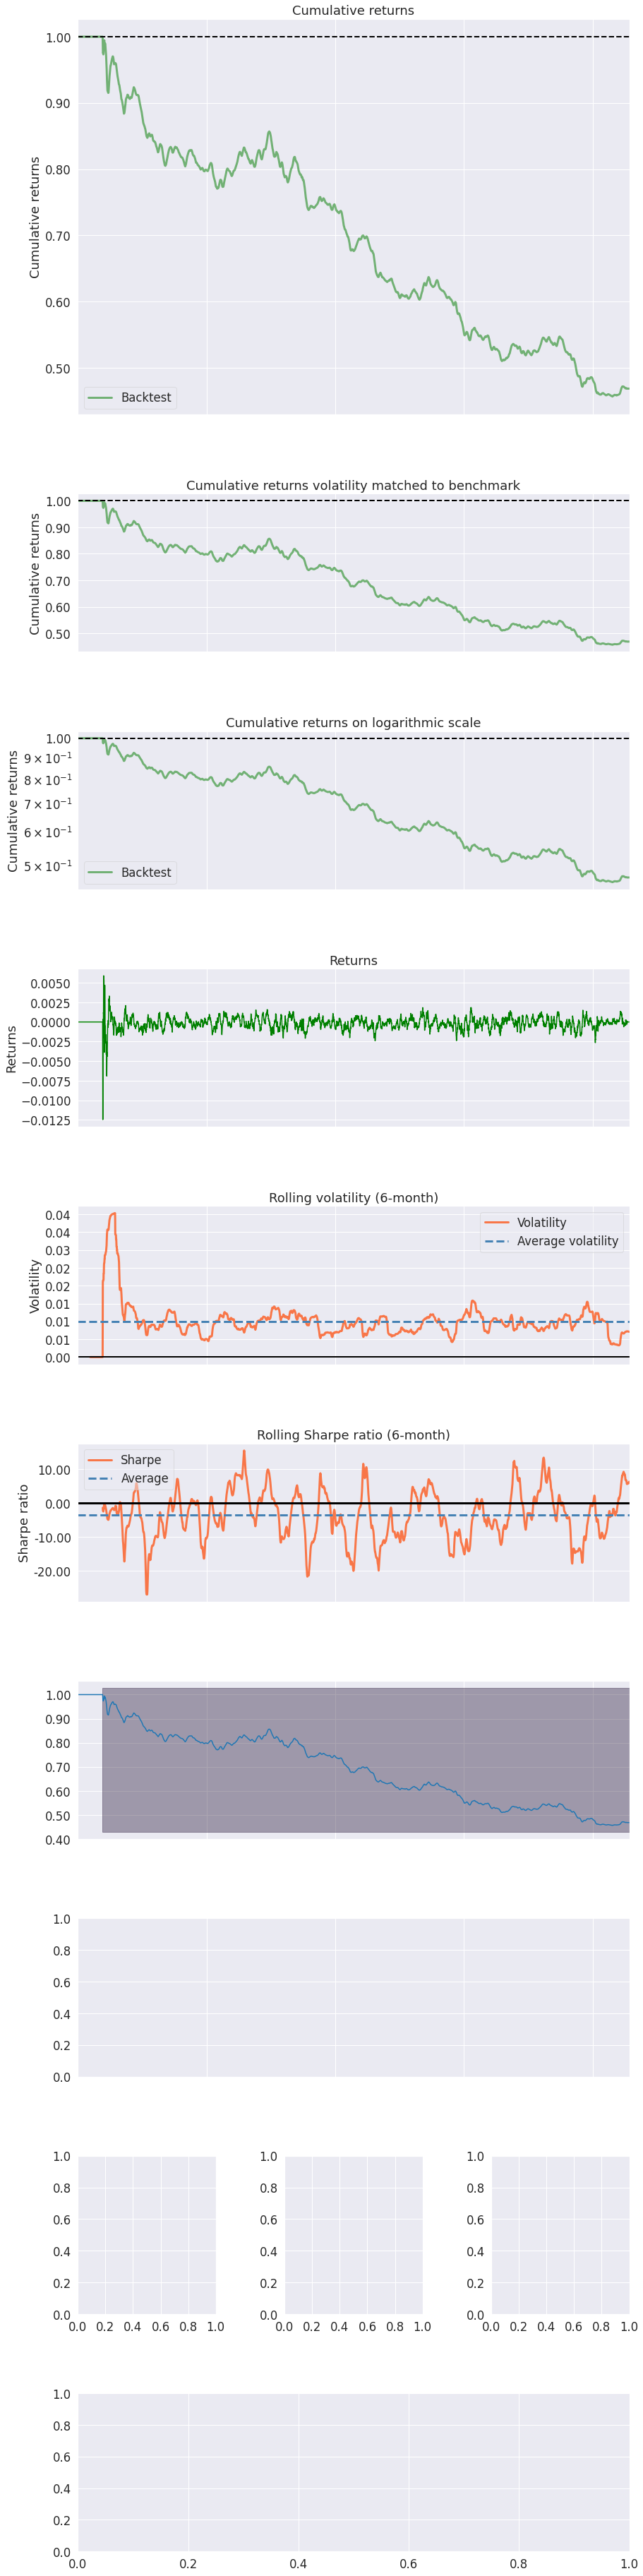

In [ ]:
lookback_period = 120
short_lookback_period = 20
long_lookback_period = 200
holding_period = 20
n_selection = 7

fixedincome_mom = Momentum(fixedincome, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False)

# Plot Cross-Sectional Weights & Time-Series Weights

## Total Portfolio

No handles with labels found to put in legend.


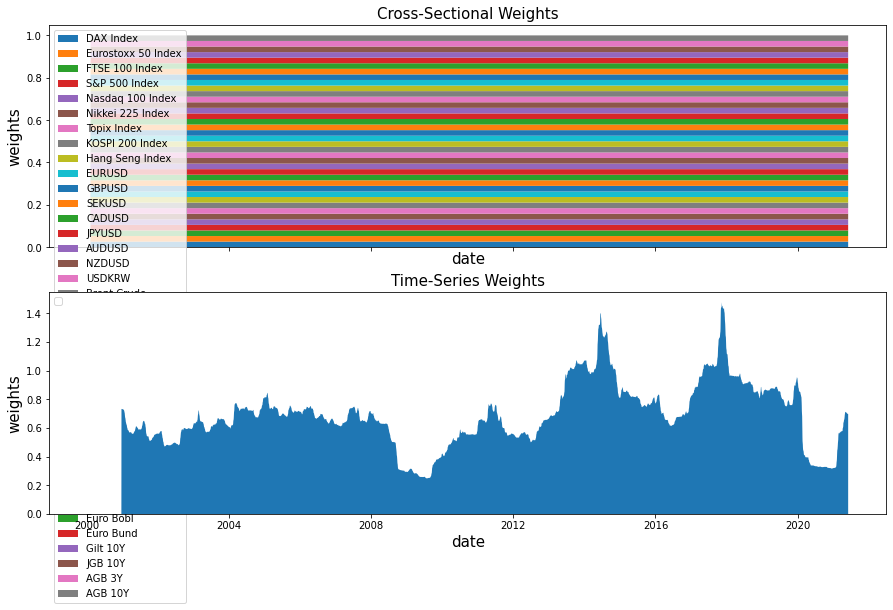

In [ ]:
port_weights = Momentum(prices, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False, show_analytics=False, show_weights=True)

## Equity

No handles with labels found to put in legend.


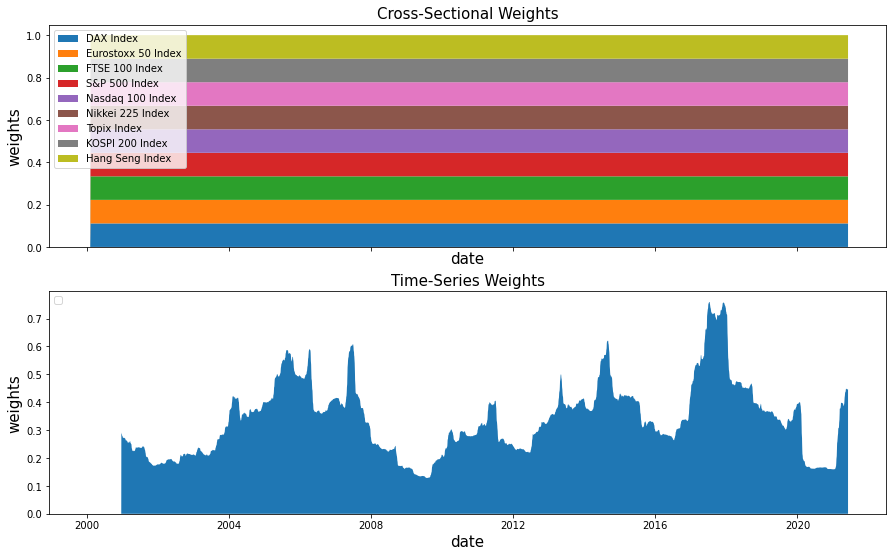

In [ ]:
equity_weights = Momentum(equity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False, show_analytics=False, show_weights=True)

No handles with labels found to put in legend.


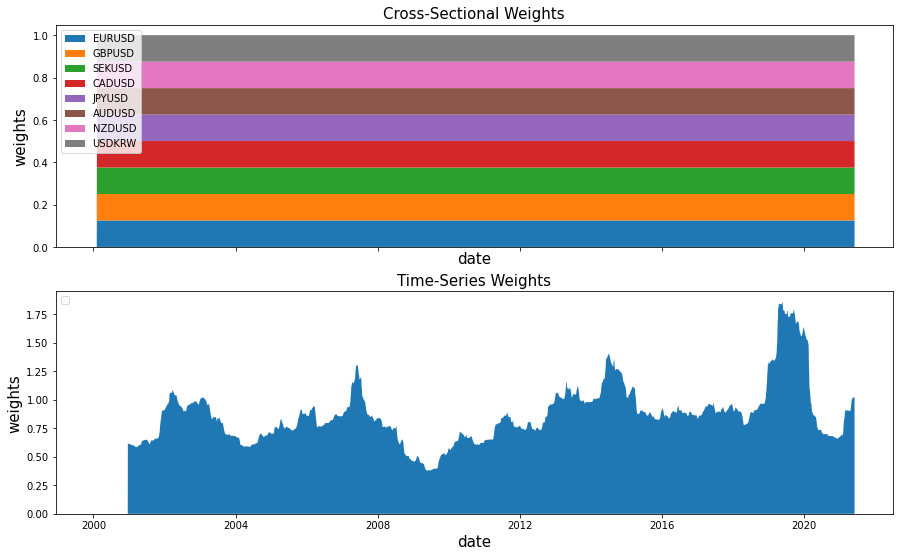

In [ ]:
currency_weights = Momentum(currency, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False, show_analytics=False, show_weights=True)

## Commodity

No handles with labels found to put in legend.


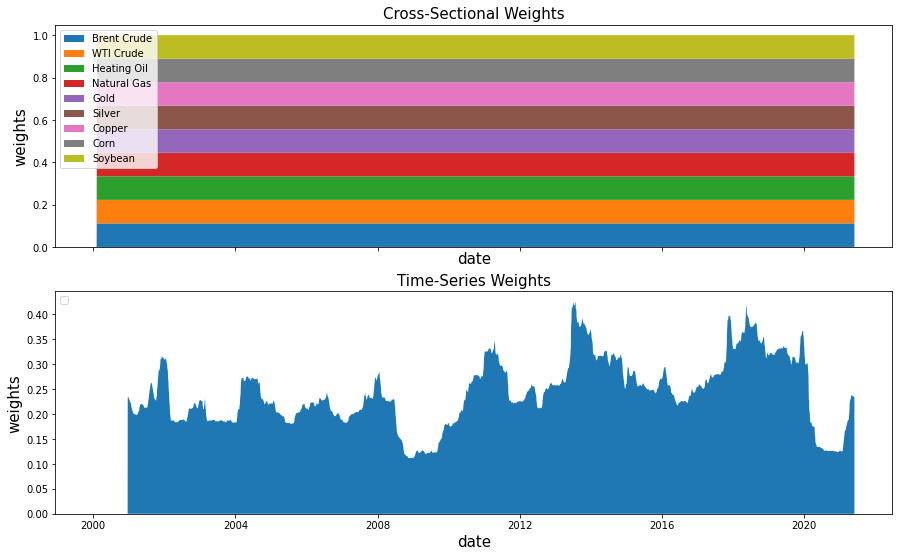

In [ ]:
commodity_weights = Momentum(commodity, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False, show_analytics=False, show_weights=True)

No handles with labels found to put in legend.


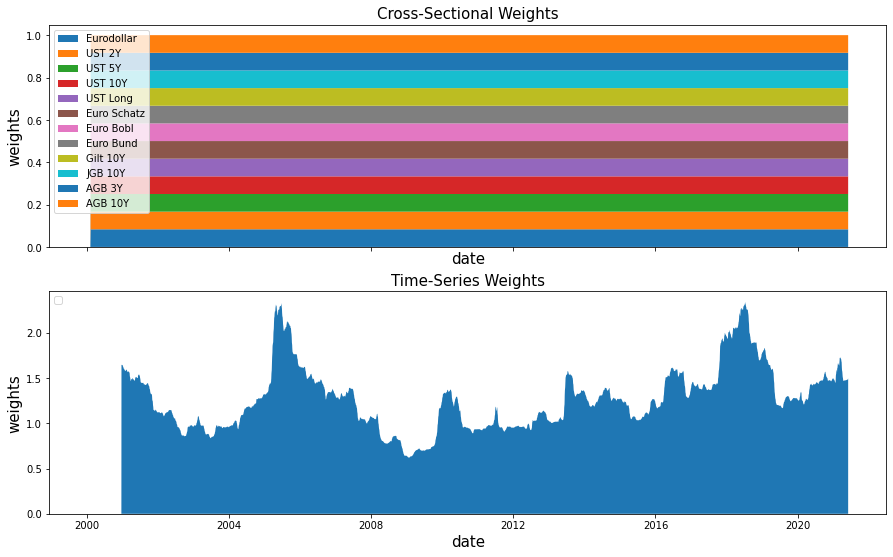

In [ ]:
fixedincome_weights = Momentum(fixedincome, lookback_period, short_lookback_period, long_lookback_period, holding_period, n_selection, show_signals=False, show_analytics=False, show_weights=True)